<a href="https://colab.research.google.com/github/LandonAmickUNCC/ECGR4105/blob/main/Homework6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Landon* Amick 801293791 Homework 4 https://github.com/LandonAmickUNCC/ECGR4105

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from mpl_toolkits import mplot3d
from ipywidgets import interact, fixed
import seaborn as sns; sns.set()
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
import time
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
import torch.optim as optim

**Part 1: Diabetes**

In [3]:
# Use the URL for the raw CSV data -- more datasets can be find here: https://github.com/satishgunjal/datasets
url = 'https://raw.githubusercontent.com/HamedTabkhi/Intro-to-ML/main/Dataset/diabetes.csv'

df = pd.read_csv(url)

# Display the first 5 rows of the DataFrame
print(df.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [4]:
# Separate features (X) and target (y) from the diabetes DataFrame
X_diabetes = df.drop('Outcome', axis=1)
y_diabetes = df['Outcome']

# Normalize the features using StandardScaler
scaler_diabetes = StandardScaler()
scaled_X_diabetes = scaler_diabetes.fit_transform(X_diabetes)

# Split the scaled diabetes data into training and testing sets (80/20 split)
X_train_diabetes_np, X_test_diabetes_np, y_train_diabetes_np, y_test_diabetes_np = train_test_split(
    scaled_X_diabetes, y_diabetes, test_size=0.2, random_state=42
)

# Convert to PyTorch tensors
X_train_diabetes = torch.from_numpy(X_train_diabetes_np).float()
X_test_diabetes = torch.from_numpy(X_test_diabetes_np).float()
y_train_diabetes = torch.from_numpy(y_train_diabetes_np.to_numpy()).long() # .to_numpy() for pandas Series
y_test_diabetes = torch.from_numpy(y_test_diabetes_np.to_numpy()).long()   # .to_numpy() for pandas Series

print(f"Diabetes X_train shape: {X_train_diabetes.shape} (type: {X_train_diabetes.dtype})")
print(f"Diabetes X_test shape: {X_test_diabetes.shape} (type: {X_test_diabetes.dtype})")
print(f"Diabetes y_train shape: {y_train_diabetes.shape} (type: {y_train_diabetes.dtype})")
print(f"Diabetes y_test shape: {y_test_diabetes.shape} (type: {y_test_diabetes.dtype})")

Diabetes X_train shape: torch.Size([614, 8]) (type: torch.float32)
Diabetes X_test shape: torch.Size([154, 8]) (type: torch.float32)
Diabetes y_train shape: torch.Size([614]) (type: torch.int64)
Diabetes y_test shape: torch.Size([154]) (type: torch.int64)


In [5]:
def diabetes_model(X, weights, bias):
    return torch.matmul(X, weights) + bias

def loss_fn(t_p, t_c):
  squared_diffs = (t_p - t_c)**2
  return squared_diffs.mean()

In [6]:
def train_diabetes_model(n_epochs, optimizer, model_nn, X_train, y_train, X_test, y_test):
    start_time = time.time()
    final_train_loss = 0.0
    for epoch in range(1, n_epochs + 1):
        optimizer.zero_grad()

        # Predict prices using the housing model
        y_pred_train = model_nn(X_train)

        # Calculate training loss (Mean Squared Error)
        loss_train = loss_fn(y_pred_train, y_train)
        final_train_loss = loss_train.item()

        # Backpropagate and update weights/bias
        loss_train.backward()
        optimizer.step()

        if epoch % 200 == 0:
            print('Epoch %d, Training Loss %f' % (epoch, float(loss_train)))

    end_time = time.time()
    total_training_time = end_time - start_time
    print(f'Total training time: {total_training_time:.2f} seconds')

    with torch.no_grad():
        y_pred_test = model_nn(X_test)
        final_validation_loss = loss_fn(y_pred_test, y_test).item()
    print(f'Final Validation Loss: {final_validation_loss:.4f}')
    return model_nn, total_training_time, final_train_loss, final_validation_loss

In [7]:
# Get the number of features from X_train_housing_tensor
num_features = X_train_diabetes.shape[1]

# Initialize weights and bias
# Weights should have a shape (num_features,)
weights = torch.randn(num_features, requires_grad=True, dtype=torch.float32)
bias = torch.zeros(1, requires_grad=True, dtype=torch.float32)

# Set learning rate and optimizer
learning_rate = 1e-6
optimizer = torch.optim.Adam([weights, bias], lr=learning_rate)

print("Number of Features:", num_features)
print("Initial Weights:", weights)
print("Initial Bias:", bias)

Number of Features: 8
Initial Weights: tensor([-0.5496,  0.7523, -0.4685,  1.0023, -0.1303, -0.0876,  0.2537,  0.2789],
       requires_grad=True)
Initial Bias: tensor([0.], requires_grad=True)


In [8]:
seq_model = nn.Sequential(nn.Linear(8,20),nn.ReLU(),nn.Linear(20,10),nn.ReLU(),nn.Linear(10,5),nn.ReLU(),nn.Linear(5,1))
seq_model

Sequential(
  (0): Linear(in_features=8, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=5, bias=True)
  (5): ReLU()
  (6): Linear(in_features=5, out_features=1, bias=True)
)

In [9]:
optimizer = torch.optim.SGD(seq_model.parameters(), lr=1e-1)
train_diabetes_model(1000, optimizer, seq_model, X_train_diabetes, y_train_diabetes.unsqueeze(1), X_test_diabetes, y_test_diabetes.unsqueeze(1))
print('output', seq_model(X_test_diabetes).squeeze(1))
print('answer', y_test_diabetes)

/tmp/ipython-input-5933150.py:19: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  print('Epoch %d, Training Loss %f' % (epoch, float(loss_train)))


Epoch 200, Training Loss 0.206420
Epoch 400, Training Loss 0.150014
Epoch 600, Training Loss 0.138742
Epoch 800, Training Loss 0.132385
Epoch 1000, Training Loss 0.126404
Total training time: 0.85 seconds
Final Validation Loss: 0.1718
output tensor([ 0.3191,  0.1285,  0.0347,  0.3330,  0.4594,  0.4111,  0.0227,  0.4975,
         0.6506,  0.5574, -0.0474,  0.5123,  0.4206,  0.5734,  0.0435,  0.4322,
         0.1049,  0.0386,  0.8341,  0.5458,  0.2404,  0.1468,  0.3503, -0.0793,
         0.5645,  0.8273,  0.0391,  0.0582,  0.0125,  0.2425,  0.7918,  0.8745,
         0.8717,  0.8605,  0.8162,  0.8180,  0.8050,  0.6215,  0.0718,  0.8663,
         0.0885,  0.6291,  0.4544,  0.4690, -0.0602,  0.6002,  0.7374,  0.2136,
         0.3443,  0.8745, -0.0467,  0.7405,  0.8745,  0.3516,  0.0542, -0.0183,
         0.6200, -0.1268,  0.4247,  0.8745,  0.6210,  0.4501,  0.4460,  0.3704,
        -0.0840,  0.5578,  0.0421,  0.6014,  0.0458,  0.5515,  0.7673,  0.1075,
         0.0346,  0.0272,  0.1242,  0.

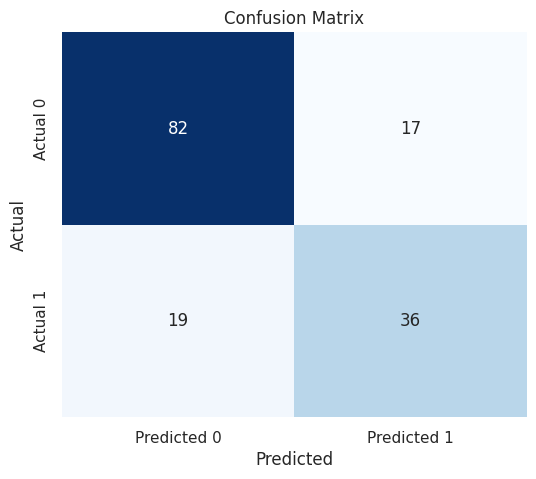


Accuracy: 0.7662
Recall: 0.6545
F1-score: 0.6667


In [10]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions from the trained model
seq_model.eval()
with torch.no_grad():
    y_pred_raw = seq_model(X_test_diabetes)

# Convert raw predictions to binary class labels (0 or 1)
# Since the labels are 0 and 1, we can threshold at 0.5
y_pred_binary = (y_pred_raw > 0.5).long().squeeze(1)

# Convert true labels to numpy for sklearn metrics
y_test_np = y_test_diabetes.cpu().numpy()
y_pred_np = y_pred_binary.cpu().numpy()

# Calculate Confusion Matrix
cm = confusion_matrix(y_test_np, y_pred_np)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Calculate Accuracy
accuracy = accuracy_score(y_test_np, y_pred_np)
print(f"\nAccuracy: {accuracy:.4f}")

# Calculate Recall
recall = recall_score(y_test_np, y_pred_np)
print(f"Recall: {recall:.4f}")

# Calculate F1-score
f1 = f1_score(y_test_np, y_pred_np)
print(f"F1-score: {f1:.4f}")


**Part 2: Cancer**

In [11]:
breast = load_breast_cancer()
breast_data = breast.data

# Normalize the data using StandardScaler
scaler = StandardScaler()
scaled_breast_data = scaler.fit_transform(breast_data)

breast_input = pd.DataFrame(scaled_breast_data)
breast_input.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,...,1.886690,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015
1,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652,...,1.805927,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190
2,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008,...,1.511870,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391
3,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919,...,-0.281464,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010
4,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450,...,1.298575,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100


In [12]:
breast_labels = breast.target
X_train, X_test, y_train, y_test = train_test_split(scaled_breast_data, breast_labels, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_cancer = torch.from_numpy(X_train).float()
X_test_cancer = torch.from_numpy(X_test).float()
y_train_cancer = torch.from_numpy(y_train).long()
y_test_cancer = torch.from_numpy(y_test).long()

print(f"X_train shape: {X_train.shape} (type: {X_train.dtype})")
print(f"X_test shape: {X_test.shape} (type: {X_test.dtype})")
print(f"y_train shape: {y_train.shape} (type: {y_train.dtype})")
print(f"y_test shape: {y_test.shape} (type: {y_test.dtype})")

X_train shape: (455, 30) (type: float64)
X_test shape: (114, 30) (type: float64)
y_train shape: (455,) (type: int64)
y_test shape: (114,) (type: int64)


In [13]:
def cancer_model(X, weights, bias):
    return torch.matmul(X, weights) + bias

In [14]:
def train_cancer_model(n_epochs, optimizer, model_nn, X_train, y_train, X_test, y_test):
    start_time = time.time()
    final_train_loss = 0.0
    for epoch in range(1, n_epochs + 1):
        optimizer.zero_grad()

        # Predict prices using the housing model
        y_pred_train = model_nn(X_train)

        # Calculate training loss (Mean Squared Error)
        loss_train = loss_fn(y_pred_train, y_train)
        final_train_loss = loss_train.item()

        # Backpropagate and update weights/bias
        loss_train.backward()
        optimizer.step()

        if epoch % 200 == 0:
            print('Epoch %d, Training Loss %f' % (epoch, float(loss_train)))

    end_time = time.time()
    total_training_time = end_time - start_time
    print(f'Total training time: {total_training_time:.2f} seconds')

    with torch.no_grad():
        y_pred_test = model_nn(X_test)
        final_validation_loss = loss_fn(y_pred_test, y_test).item()
    print(f'Final Validation Loss: {final_validation_loss:.4f}')
    return model_nn, total_training_time, final_train_loss, final_validation_loss

In [15]:
# Get the number of features from X_train_housing_tensor
num_features = X_train_cancer.shape[1]

# Initialize weights and bias
# Weights should have a shape (num_features,)
weights = torch.randn(num_features, requires_grad=True, dtype=torch.float32)
bias = torch.zeros(1, requires_grad=True, dtype=torch.float32)

# Set learning rate and optimizer
learning_rate = 1e-1
optimizer = torch.optim.Adam([weights, bias], lr=learning_rate)

print("Number of Features:", num_features)
print("Initial Weights:", weights)
print("Initial Bias:", bias)

Number of Features: 30
Initial Weights: tensor([ 1.0971,  0.6979,  0.3079,  0.3173,  1.2114, -0.2820,  0.5155, -0.1773,
         0.3452, -1.8596,  2.0953,  1.1175,  0.4075,  0.4874, -0.7151,  0.3892,
         0.1440,  0.2238, -0.8333,  0.9517,  0.1359, -1.3263,  0.4609,  1.9886,
        -0.8850,  1.3935,  1.1033, -0.0032,  0.5561,  1.9250],
       requires_grad=True)
Initial Bias: tensor([0.], requires_grad=True)


In [16]:
seq_model = nn.Sequential(nn.Linear(30,10),nn.ReLU(),nn.Linear(10,5),nn.ReLU(),nn.Linear(5,1))
seq_model

Sequential(
  (0): Linear(in_features=30, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=5, bias=True)
  (3): ReLU()
  (4): Linear(in_features=5, out_features=1, bias=True)
)

In [17]:
optimizer = torch.optim.SGD(seq_model.parameters(), lr=1e-1)
train_cancer_model(200, optimizer, seq_model, X_train_cancer, y_train_cancer.unsqueeze(1), X_test_cancer, y_test_cancer.unsqueeze(1))
print('output', seq_model(X_test_cancer).squeeze(1))
print('answer', y_test_cancer)

Epoch 200, Training Loss 0.020139
Total training time: 0.13 seconds
Final Validation Loss: 0.0204
output tensor([ 0.7998,  0.0390,  0.0668,  0.9750,  1.0692, -0.0795,  0.0601,  0.0731,
         0.5983,  1.0248,  0.9010,  0.0790,  0.9600,  0.0328,  1.0143,  0.1396,
         0.9844,  1.1037,  1.0923,  0.0359,  0.8420,  0.9459, -0.0559,  1.0494,
         0.9842,  0.9707,  1.0121,  0.9713,  0.9844, -0.0337,  1.0090,  1.0288,
         0.8619,  0.9581,  1.0122,  0.9131,  0.0903,  0.8831,  0.0452,  0.8684,
         1.0475,  0.0305,  1.0205,  0.9737,  0.8756,  0.7941,  0.9274,  0.9448,
         0.8830,  1.0251,  0.0680,  0.0567,  0.6990,  1.0040,  0.9821,  0.8987,
         1.0013, -0.0871,  0.1207,  1.0508,  0.9479, -0.0307, -0.0198,  0.8100,
         0.9727,  0.7674, -0.0187, -0.1370,  0.9845,  0.8345,  0.0116, -0.0134,
         0.9875, -0.0134,  0.9425,  0.9783,  0.8994,  0.5155,  1.0748,  0.9171,
         0.1026,  1.0430,  0.3662,  0.0781,  0.0439, -0.0244, -0.0720,  0.0893,
         1.0410

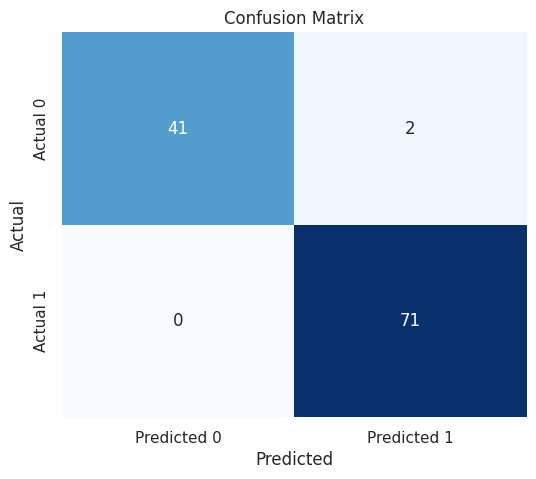


Accuracy: 0.9825
Recall: 1.0000
F1-score: 0.9861


In [18]:
# Get predictions from the trained model
seq_model.eval()
with torch.no_grad():
    y_pred_raw = seq_model(X_test_cancer)

# Convert raw predictions to binary class labels (0 or 1)
# Since the labels are 0 and 1, we can threshold at 0.5
y_pred_binary = (y_pred_raw > 0.5).long().squeeze(1)

# Convert true labels to numpy for sklearn metrics
y_test_np = y_test_cancer.cpu().numpy()
y_pred_np = y_pred_binary.cpu().numpy()

# Calculate Confusion Matrix
cm = confusion_matrix(y_test_np, y_pred_np)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Calculate Accuracy
accuracy = accuracy_score(y_test_np, y_pred_np)
print(f"\nAccuracy: {accuracy:.4f}")

# Calculate Recall
recall = recall_score(y_test_np, y_pred_np)
print(f"Recall: {recall:.4f}")

# Calculate F1-score
f1 = f1_score(y_test_np, y_pred_np)
print(f"F1-score: {f1:.4f}")


**Part 3A**

In [7]:
from torchvision import datasets

import torchvision.transforms as transforms

data_path = './data-unversioned/p1ch7/'

cifar10_val = datasets.CIFAR10(data_path, train=False, download=True, transform=transforms.ToTensor())

transformed_cifar10_train = datasets.CIFAR10(data_path, train=True, download=True, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.4915,0.4823,0.4468),(0.2470,0.2435,0.2616))]))

100%|██████████| 170M/170M [00:02<00:00, 67.5MB/s]


In [8]:
def softmax(x):
  return torch.exp(x)/torch.exp(x).sum()

n_out = 10

cifar_model1 = nn.Sequential(nn.Linear(3072,512),nn.ReLU(),nn.Linear(512,n_out),nn.LogSoftmax(dim=1))

In [9]:
learning_rate = 1e-2

optimizer = optim.SGD(cifar_model1.parameters(), lr=learning_rate)

loss_fn_cifar= nn.NLLLoss()

n_epochs = 200

def train_cifar_model1(n_epochs, optimizer, model_nn, train_dataset, val_dataset):
    start_time = time.time()

    # Create DataLoaders for batching
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

    for epoch in range(1, n_epochs + 1):
        model_nn.train() # Set model to training mode
        running_loss = 0.0
        for imgs, labels in train_loader:
            # Flatten images for the linear model
            imgs = imgs.view(imgs.shape[0], -1)

            optimizer.zero_grad()
            out = model_nn(imgs)
            loss = loss_fn_cifar(out, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)

        # Validation phase
        model_nn.eval() # Set model to evaluation mode
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs = imgs.view(imgs.shape[0], -1)
                out = model_nn(imgs)
                val_loss = loss_fn_cifar(out, labels)
                val_running_loss += val_loss.item()

                _, predicted = torch.max(out.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_running_loss / len(val_loader)
        val_accuracy = 100 * correct / total

    end_time = time.time()
    total_training_time = end_time - start_time
    if epoch % 20 == 0:
      print(f'Epoch {epoch}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
      print(f"Epoch {epoch}, Training Loss: {avg_train_loss:.4f}")
      print(f'Total training time: {total_training_time:.2f} seconds')
    return model_nn, total_training_time, avg_train_loss, avg_val_loss

In [22]:
train_cifar_model1(n_epochs, optimizer, cifar_model1, transformed_cifar10_train, cifar10_val)

Epoch 200, Validation Loss: 2.8306, Validation Accuracy: 31.25%
Epoch 200, Training Loss: 0.0057
Total training time: 3679.38 seconds


(Sequential(
   (0): Linear(in_features=3072, out_features=512, bias=True)
   (1): ReLU()
   (2): Linear(in_features=512, out_features=10, bias=True)
   (3): LogSoftmax(dim=1)
 ),
 3679.375561952591,
 0.005660504565093085,
 2.8305889527509165)

**Part 3B**

In [10]:
n_out = 10

cifar_model2 = nn.Sequential(nn.Linear(3072,512),nn.ReLU(),nn.Linear(512,256),nn.ReLU(),nn.Linear(256,128),nn.ReLU(),nn.Linear(128,n_out),nn.LogSoftmax(dim=1))

In [11]:
learning_rate = 1e-2

optimizer = optim.SGD(cifar_model2.parameters(), lr=learning_rate)

loss_fn_cifar2= nn.NLLLoss()

n_epochs = 300

def train_cifar_model2(n_epochs, optimizer, model_nn, train_dataset, val_dataset):
    start_time = time.time()

    # Create DataLoaders for batching
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

    for epoch in range(1, n_epochs + 1):
        model_nn.train() # Set model to training mode
        running_loss = 0.0
        for imgs, labels in train_loader:
            # Flatten images for the linear model
            imgs = imgs.view(imgs.shape[0], -1)

            optimizer.zero_grad()
            out = model_nn(imgs)
            loss = loss_fn_cifar2(out, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)

        # Validation phase
        model_nn.eval() # Set model to evaluation mode
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs = imgs.view(imgs.shape[0], -1)
                out = model_nn(imgs)
                val_loss = loss_fn_cifar2(out, labels)
                val_running_loss += val_loss.item()

                _, predicted = torch.max(out.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_running_loss / len(val_loader)
        val_accuracy = 100 * correct / total

    end_time = time.time()
    total_training_time = end_time - start_time
    if epoch % 20 == 0:
      print(f'Epoch {epoch}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
      print(f"Epoch {epoch}, Training Loss: {avg_train_loss:.4f}")
      print(f'Total training time: {total_training_time:.2f} seconds')
    return model_nn, total_training_time, avg_train_loss, avg_val_loss

In [12]:
train_cifar_model2(n_epochs, optimizer, cifar_model2, transformed_cifar10_train, cifar10_val)

Epoch 300, Validation Loss: 4.0352, Validation Accuracy: 30.63%
Epoch 300, Training Loss: 0.0001
Total training time: 6504.90 seconds


(Sequential(
   (0): Linear(in_features=3072, out_features=512, bias=True)
   (1): ReLU()
   (2): Linear(in_features=512, out_features=256, bias=True)
   (3): ReLU()
   (4): Linear(in_features=256, out_features=128, bias=True)
   (5): ReLU()
   (6): Linear(in_features=128, out_features=10, bias=True)
   (7): LogSoftmax(dim=1)
 ),
 6504.90038394928,
 0.00013896675178595215,
 4.03523091601718)